In [47]:
# import
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import datetime as dt
import numpy as np
import random
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from IPython import display
import time
from pathlib import Path
import pandas as pd
import os
import copy
import networkx as nx
import pickle
import sys
from collections import Counter
from scipy import stats
%matplotlib inline

# change directory

os.chdir("/home/kyoko/Develop/ActualCausation/MABE/MABE_contents/actual_agency")

# import packages -- pyphi

from pyanimats import *
from pyTPM import *
import actual_agency as agency
import pyphi
from pyphi import actual, config, Direction

pyphi.config.VALIDATE_SUBSYSTEM_STATES = False
pyphi.config.PARTITION_TYPE = 'TRI'

# Change directory back to Example directory, now in MABE_contents
os.chdir("../Experiments/analysis_now")

%load_ext autoreload
%autoreload 2
%aimport pyTPM, pyanimats, actual_agency

# # omajinai to plotting
# plt.style.use('ggplot') 
# font = {'family' : 'meiryo'}
# matplotlib.rc('font', **font)

# make an array
datas = np.zeros(3000).reshape(250, 12)

prearr = np.sort(np.tile(np.arange(1,11), (1,5))).reshape(50, 1) 
runarr = np.tile(prearr.copy(), (5,1)) #Runs
hidarr = np.sort(np.tile(np.arange(2,7), (1,50))).reshape(250, 1) #Hidden nodes
stsarr = np.tile(np.arange(1,6), (1,50)).reshape(250, 1)

datas[:,0:1] = hidarr
datas[:,1:2] = runarr
datas[:,2:3] = stsarr

# defining some parameters to use 
generations = 30000
n_agents = int(generations/500.+1)
n_runs = 10
n_trials = 64
n_data = 5

agent = 60 # saved generation
trial = 60 # 0~63
run = 1 # 0 ~ n_runs-1 change only this


# Get Line-of-descent (LOD) data from MABE output
    
LOD_data = ['190822_7156331_h2_LOD_data.pkl','190822_7156331_h3_LOD_data.pkl','190822_7156331_h4_LOD_data.pkl','190822_7156331_h5_LOD_data.pkl','190822_7156331_h6_LOD_data.pkl']
LODs = []    
for i in range(len(LOD_data)):
    with open(LOD_data[i],'rb') as f:
        LODs.append(pickle.load(f))

# Get genome data
all_genomes = ['190822_7156331_h2_genome.pkl','190822_7156331_h3_genome.pkl','190822_7156331_h4_genome.pkl','190822_7156331_h5_genome.pkl','190822_7156331_h6_genome.pkl']
genomes = []
for i in range(len(all_genomes)):
    with open(all_genomes[i],'rb') as f:
        genomes.append(pickle.load(f))


# Get activity data
all_activity = ['190822_7156331_h2_activity.pkl','190822_7156331_h3_activity.pkl','190822_7156331_h4_activity.pkl','190822_7156331_h5_activity.pkl','190822_7156331_h6_activity.pkl']
activities = []
for i in range(len(all_activity)):
    with open(all_activity[i],'rb') as f:
        activities.append(pickle.load(f))


# Define functions to find states
# find the most frequent state


def counting3(data):
    c = Counter(data)
    freq_scores = c.most_common()
    if len(freq_scores) < 3:
        return(freq_scores)
    else:
        third_count = freq_scores[2][1]
    
        modes = [freq_scores[0][:], freq_scores[1][:]]
        for p in range(2,len(freq_scores)): #出現回数を比較、追加
            if freq_scores[p][1] == third_count and p < 5:
                modes.append(freq_scores[p])
        return(modes)

# change num(10) to bin(2)
def int2binary(n,node_n):
    holi = [int(x) for x in bin(n)[2:].zfill(node_n)]
    holi.reverse()
    return holi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def num2state(num,n_nodes):
 
    number = '{0:0' + str(n_nodes) + 'b}'
    state = number.format(num)
    state = [int(i) for i in state]

    # returns the state
    return state

In [115]:
# brain acivity, genome, TPM, TPM_gates, cm
genome = []
TPM, TPM_gates, cm = [],[],[]
n_connection = np.zeros(n_data*n_runs)
brain_activity = []

for data in range(n_data):
    n_hnodes = data+2
    for n in range(n_runs):
        place = 5*data + n
        
        # culculate brain activity
        ##brain_activity.append(agency.getBrainActivity(activities[data][n],n_agents=n_agents, n_nodes=n_hnodes+4, n_hidden=n_hnodes))
        #actarr = brain_activity[place][agent][trial]

        


Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating activity matrix from MABE output...
Creating a

In [4]:

for data in range(n_data):
    n_hnodes = data+2
    for n in range(n_runs):
        place = 5*data + n
        genome.append(agency.get_genome(genomes[data], n, agent))
#print(len(genome[4]))

        a, b, c = genome2TPM(genome[place], n_nodes=n_hnodes+4, n_sensors=2, n_motors=2, gate_type='deterministic',states_convention='loli',remove_sensor_motor_effects=True)
        TPM.append(a)
        TPM_gates.append(b)
        cm.append(c)
        

In [156]:
# fitness
fitness = np.zeros(50)
for data in range(n_data):
    for n in range(n_runs):
        LODs[data][n]['fitness'] = (LODs[data][n]['correct_AVE']
                               /(LODs[data][n]['correct_AVE']+LODs[data][n]['incorrect_AVE']))
        fitness[data*10+n] += LODs[data][n]['fitness'][60]

In [157]:
fitness

array([0.8515625, 0.8203125, 0.84375  , 0.75     , 0.90625  , 0.765625 ,
       0.875    , 0.8125   , 0.703125 , 0.828125 , 0.8671875, 0.75     ,
       0.890625 , 0.921875 , 0.8359375, 0.96875  , 0.90625  , 0.859375 ,
       0.859375 , 0.65625  , 0.9921875, 0.890625 , 0.8125   , 0.875    ,
       0.8125   , 0.875    , 0.9296875, 0.875    , 0.765625 , 0.6953125,
       0.90625  , 0.7421875, 0.890625 , 0.8125   , 0.671875 , 0.9765625,
       0.71875  , 0.9140625, 0.953125 , 0.875    , 0.71875  , 0.9296875,
       0.7578125, 1.       , 0.8515625, 0.9453125, 0.8828125, 0.8359375,
       0.8359375, 0.9921875])

In [153]:
prestate = np.array([[[36, 16, 4], [20,56], [36,8], [0,16,48,40], [32,0,36], [40,56,14,41],[52,12],[5,24,12], [0,20], [0,52]],
[[112,0,56,24], [0,24,18,70], [84,44,68], [60,12,120,72,121],[32,52,60], [53,100,48,112,40], [48,49,97,107,72], [44,4],[84,108], [32,8,40]],
 [[184,92,93,235,191], [216,92,217,125,111], [212,76,92,196], [32,8,2], [144,146,145,129,163], [172,228,236], [236,220,8,79,204], [212, 96],[44,80,96], [4]],
 [[16,272,388], [192,456,462,198], [376,371,370], [24,8,168,68], [36], [404,220,144], [100], [0,328,288,228], [21,28,72], [12,296,280]],
 [[516], [164,416,484], [608,628,540,520], [708,136], [560,561,563,547,610], [556,564,812], [156,664,728], [80,372,244,116,16], [256,272,464], [244, 112, 372]]])

In [6]:
# 今後しばしばstateがいくつあるかを使うので。

nstate = np.zeros_like(prestate)
for i in range(len(nstate)):
    for j in range(len(nstate[i])):
        nstate[i,j] += len(prestate[i,j])
nstate

array([[3, 2, 2, 4, 3, 4, 2, 3, 2, 2],
       [4, 4, 3, 5, 3, 5, 5, 2, 2, 3],
       [5, 5, 4, 3, 5, 3, 5, 2, 3, 1],
       [3, 4, 3, 4, 1, 3, 1, 4, 3, 3],
       [1, 3, 4, 2, 5, 3, 3, 5, 3, 3]], dtype=object)

In [7]:
state = []
for i in range(len(prestate)):
    for j in range(len(nstate[i])):
        for k in range(nstate[i,j]):
            state.append(np.array(num2state(prestate[i][j][k], 6+i)))
state = np.array(state)
state

array([array([1, 0, 0, 1, 0, 0]), array([0, 1, 0, 0, 0, 0]),
       array([0, 0, 0, 1, 0, 0]), array([0, 1, 0, 1, 0, 0]),
       array([1, 1, 1, 0, 0, 0]), array([1, 0, 0, 1, 0, 0]),
       array([0, 0, 1, 0, 0, 0]), array([0, 0, 0, 0, 0, 0]),
       array([0, 1, 0, 0, 0, 0]), array([1, 1, 0, 0, 0, 0]),
       array([1, 0, 1, 0, 0, 0]), array([1, 0, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0]), array([1, 0, 0, 1, 0, 0]),
       array([1, 0, 1, 0, 0, 0]), array([1, 1, 1, 0, 0, 0]),
       array([0, 0, 1, 1, 1, 0]), array([1, 0, 1, 0, 0, 1]),
       array([1, 1, 0, 1, 0, 0]), array([0, 0, 1, 1, 0, 0]),
       array([0, 0, 0, 1, 0, 1]), array([0, 1, 1, 0, 0, 0]),
       array([0, 0, 1, 1, 0, 0]), array([0, 0, 0, 0, 0, 0]),
       array([0, 1, 0, 1, 0, 0]), array([0, 0, 0, 0, 0, 0]),
       array([1, 1, 0, 1, 0, 0]), array([1, 1, 1, 0, 0, 0, 0]),
       array([0, 0, 0, 0, 0, 0, 0]), array([0, 1, 1, 1, 0, 0, 0]),
       array([0, 0, 1, 1, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0]),
       ar

In [8]:
cm = np.array(cm)
for i in range(50):
    print(pyphi.connectivity.is_strong(cm[i][4:,4:]))

False
False
False
True
False
True
True
True
False
False
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
False
False


In [11]:
# compute major complexes and 

num_connected = []
MC = []
count = 0

for i in range(50):
    network = pyphi.network.Network(TPM[i],cm[i])
    #sta = tuple(cm[i][0,:].astype(int))
    row = int(i/10)
    cul = i%10
    #print(row, cul)
    for j in range(len(prestate[row][cul])):
        print(state[count+j])
        MC.append(pyphi.compute.network.major_complex(network,state[count+j]))
        num_connected.append(len(list(pyphi.compute.network.possible_complexes(network, state[count+j]))))
    count = count+j+1 
    #print(j, count)
    
    

Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 1 0 0]
[0 1 0 0 0 0]
[0 0 0 1 0 0]
[0 1 0 1 0 0]
[1 1 1 0 0 0]
[1 0 0 1 0 0]
[0 0 1 0 0 0]
[0 0 0 0 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 0 0 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 0 0 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 1 0 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 0 0 0]
[0 0 0 0 0 0]
[1 0 0 1 0 0]
[1 0 1 0 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 1 0 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 1 1 1 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 1 0 0 1]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 0 1 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 1 1 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 0 1 0 1]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 0 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 1 1 0 0]



Finding complexes:   0%|          | 0/1 [00:00<?, ?it/s]        

[0 0 0 0 0 0]
[0 1 0 1 0 0]
[0 0 0 0 0 0]
[1 1 0 1 0 0]
[1 1 1 0 0 0 0]
[0 0 0 0 0 0 0]
[0 1 1 1 0 0 0]
[0 0 1 1 0 0 0]
[0 0 0 0 0 0 0]
[0 0 1 1 0 0 0]
[0 0 1 0 0 1 0]
[1 0 0 0 1 1 0]
[1 0 1 0 1 0 0]
[0 1 0 1 1 0 0]
[1 0 0 0 1 0 0]
[0 1 1 1 1 0 0]


Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[0 0 0 1 1 0 0]
[1 1 1 1 0 0 0]
[1 0 0 1 0 0 0]
[1 1 1 1 0 0 1]
[0 1 0 0 0 0 0]



Computing concepts:  57%|█████▋    | 4/7 [00:00<00:00, 35.78it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]
                                                         
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.44it/s]
                                                                 
Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[0 1 1 0 1 0 0]



Computing concepts:  29%|██▊       | 2/7 [00:00<00:00, 19.79it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]
                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]
                                                         
Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[0 1 1 1 1 0 0]



Computing concepts:  29%|██▊       | 2/7 [00:00<00:00, 18.53it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]
                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]
                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 0 1 0 1]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.53it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 0 0 1 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 0 0 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 1 0 0 0 0]



Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 18.97it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 0 1 0 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 0 0 0 0]
[0 1 1 0 0 0 1]
[1 1 0 0 0 0 1]
[1 1 0 1 0 1 1]
[1 0 0 1 0 0 0]
[0 1 0 1 1 0 0]
[0 0 0 0 1 0 0]
[1 0 1 0 1 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 0 1 1 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 0 0 0 0 0]
[0 0 0 1 0 0 0]
[0 1 0 1 0 0 0]
[1 0 1 1 1 0 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 0 1 1 1 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 0 1 1 1 0 1]



Computing concepts: 100%|██████████| 3/3 [00:00<00:00, 29.83it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 1 0 1 0 1 1]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 1 1 1 1 1 1]



Finding complexes:   0%|          | 0/3 [00:00<?, ?it/s]        

[1 1 0 1 1 0 0 0]
[0 1 0 1 1 1 0 0]
[1 1 0 1 1 0 0 1]
[0 1 1 1 1 1 0 1]
[0 1 1 0 1 1 1 1]
[1 1 0 1 0 1 0 0]
[0 1 0 0 1 1 0 0]
[0 1 0 1 1 1 0 0]
[1 1 0 0 0 1 0 0]
[0 0 1 0 0 0 0 0]
[0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 1 0]
[1 0 0 1 0 0 0 0]
[1 0 0 1 0 0 1 0]
[1 0 0 1 0 0 0 1]
[1 0 0 0 0 0 0 1]


Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[1 0 1 0 0 0 1 1]
[1 0 1 0 1 1 0 0]



Computing concepts:  29%|██▊       | 2/7 [00:00<00:00, 17.45it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]
                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]
                                                         
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.36it/s]
                                                                 
Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[1 1 1 0 0 1 0 0]



Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  9.98it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]
                                                         
Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[1 1 1 0 1 1 0 0]



Computing concepts:  43%|████▎     | 3/7 [00:00<00:00, 28.53it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 1 0 1 1 0 0]
[1 1 0 1 1 1 0 0]
[0 0 0 0 1 0 0 0]
[0 1 0 0 1 1 1 1]
[1 1 0 0 1 1 0 0]
[1 1 0 1 0 1 0 0]



                                                         
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 0 0 0 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.91it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 1 0 1 1 0 0]
[0 1 0 1 0 0 0 0]
[0 1 1 0 0 0 0 0]
[0 0 0 0 0 1 0 0]
[0 0 0 0 1 0 0 0 0]



Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 19.38it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 0 1 0 0 0 0]



Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 18.67it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 0 0 0 0 1 0 0]



Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 18.14it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[0 1 1 0 0 0 0 0 0]



Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.60it/s]
                                                                   
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  8.70it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  9.35it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00, 12.45it/s]
                                                                 
Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 19.83it/s]
                                                                 
Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 19.73it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.79it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[1 1 1 0 0 1 0 0 0]



Computing concepts:  80%|████████  | 12/15 [00:00<00:00, 14.37it/s]
                                                                   
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  7.57it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  8.13it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00, 11.73it/s]
                                                                 
Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 19.32it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.92it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[1 1 1 0 0 1 1 1 0]



Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 13.04it/s]
                                                                   
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  8.88it/s]
                                                                 
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  8.03it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00, 11.40it/s]
                                                                 
Computing concepts: 100%|██████████| 3/3 [00:00<00:00, 28.32it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.95it/s]
                                                                 
Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 19.98it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[0 1 1 0 0 0 1 1 0]



Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 13.29it/s]
                                                                   
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  8.09it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00, 12.15it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00, 10.47it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.78it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.83it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 1 1 1 1 0 0 0]



Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 19.98it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 1 1 1 0 0 1 1]



Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 18.43it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 1 1 1 0 0 1 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.80it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[0 0 0 0 1 1 0 0 0]



Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 16.80it/s]
                                                                   
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  9.07it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  8.34it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  9.25it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.85it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[0 0 0 0 0 1 0 0 0]



Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 15.30it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.40it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  9.36it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  8.58it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.88it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[0 1 0 1 0 1 0 0 0]



Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.51it/s]
                                                                   
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  7.97it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  9.53it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  9.06it/s]
                                                                 
Computing concepts:  67%|██████▋   | 2/3 [00:00<00:00, 19.61it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[0 0 1 0 0 0 1 0 0]



Computing concepts:  80%|████████  | 12/15 [00:00<00:00, 12.57it/s]
                                                                   
Computing concepts: 100%|██████████| 7/7 [00:00<00:00, 10.55it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  8.68it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:00,  8.52it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.34it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 0 1 0 0 1 0 0]
[1 1 0 0 1 0 1 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 0 1 1 1 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 0 0 1 0 0 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.06it/s]


[0 0 1 1 0 0 1 0 0]


Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 0 0 0 0 0 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.17it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 1 0 0 1 0 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.42it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 1 0 0 0 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.59it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 1 0 0 1 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.47it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 0 0 1 0 1 0 1]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.33it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 0 0 1 1 1 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.79it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 1 0 0 1 0 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  9.20it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[0 0 0 0 0 1 1 0 0]
[1 0 0 1 0 1 0 0 0]
[1 0 0 0 1 1 0 0 0]
[1 0 0 0 0 0 0 1 0 0]



Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.64it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.50it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.66it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.34it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 0 1 0 1 0 0 1 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.85it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 0 1 0 0 0 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.88it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[0 1 1 1 1 0 0 1 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.99it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 1 1 0 0 0 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 1 1 1 0 1 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 0 0 1 1 1 0 0]



Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 0 0 0 1 0 0 0]



Computing concepts:   0%|          | 0/31 [00:00<?, ?it/s]

[1 0 1 1 0 0 0 1 0 0]



Computing concepts: 100%|██████████| 31/31 [00:08<00:00,  1.64it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 13.06it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 10.46it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:01<00:00,  7.00it/s]
                                                                   
Evaluating Φ cuts: 100%|██████████| 14/14 [00:06<00:00,  2.47it/s]


Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.94it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.80it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.98it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  9.42it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.39it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.68it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.62it/s]
                                                                 
Computing concepts:   0%|          | 0/31 [00:00<?, ?it/s]

[0 0 1 0 0 0 1 0 0 0]



Computing concepts: 100%|██████████| 31/31 [00:13<00:00,  1.04it/s]
                                                                   
Computing concepts:  93%|█████████▎| 14/15 [00:01<00:00,  9.93it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:01<00:00, 10.63it/s]
                                                                   
Computing concepts:  93%|█████████▎| 14/15 [00:01<00:00,  9.85it/s]
                                                                   
Evaluating Φ cuts:  71%|███████▏  | 10/14 [00:06<00:02,  1.52it/s]


Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  7.60it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  5.48it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  9.52it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.31it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.02it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.04it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.78it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.73it/s]
          

[1 0 0 0 1 1 0 0 0 0]



Computing concepts:  93%|█████████▎| 14/15 [00:01<00:00, 10.25it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.29it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  9.25it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  6.04it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.38it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[1 0 0 0 1 1 0 0 0 1]



Computing concepts:  93%|█████████▎| 14/15 [00:01<00:00,  9.81it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.09it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.50it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.81it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.17it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.85it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[1 0 0 0 1 1 0 0 1 1]



Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00,  9.92it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.59it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.09it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.79it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.57it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[1 0 0 0 1 0 0 0 1 1]



Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 11.07it/s]
                                                                   
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  8.17it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.48it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.58it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.04it/s]
                                                                 
Computing concepts:   0%|          | 0/15 [00:00<?, ?it/s]

[1 0 0 1 1 0 0 0 1 0]



Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 13.32it/s]
                                                                   
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  8.16it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.38it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  6.96it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.00it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 0 1 0 1 1 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.52it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 0 0 0 1 1 0 1 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.04it/s]
                                                                 
Computing concepts:   0%|          | 0/3 [00:00<?, ?it/s]

[1 1 0 0 1 0 1 1 0 0]



Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.00it/s]
                                                                 
Computing concepts:   0%|          | 0/31 [00:00<?, ?it/s]

[0 0 1 0 0 1 1 1 0 0]



Computing concepts:  94%|█████████▎| 29/31 [00:01<00:00, 16.06it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 13.12it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 13.93it/s]
                                                                   
Computing concepts:   0%|          | 0/31 [00:00<?, ?it/s]

[1 0 1 0 0 1 1 0 0 0]



Computing concepts:  90%|█████████ | 28/31 [00:00<00:00, 23.96it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 14.18it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 15.37it/s]
                                                                   
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  8.32it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.67it/s]
                                                                 
Computing concepts:   0%|          | 0/31 [00:00<?, ?it/s]

[1 0 1 1 0 1 1 0 0 0]



Computing concepts:  97%|█████████▋| 30/31 [00:01<00:00, 24.76it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 14.30it/s]
                                                                   
Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 14.14it/s]
                                                                   
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  9.12it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.32it/s]
                                                                 
Computing concepts:   0%|          | 0/63 [00:00<?, ?it/s]

[0 0 0 1 0 1 0 0 0 0]



Computing concepts: 100%|██████████| 63/63 [00:10<00:00,  3.19it/s]
                                                                   
Computing concepts:  90%|█████████ | 28/31 [00:01<00:00, 23.06it/s]
                                                                   
Evaluating Φ cuts:  17%|█▋        | 5/30 [00:02<00:19,  1.27it/s]


Computing concepts: 100%|██████████| 31/31 [00:01<00:00, 19.23it/s]
                                                                   
Computing concepts: 100%|██████████| 31/31 [00:02<00:00, 12.73it/s]
                                                                   
Computing concepts:  97%|█████████▋| 30/31 [00:01<00:00, 13.59it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.61it/s]
                                                                   
Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 12.83it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 12.97it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.55it/s]
                                                                   
Evaluating Φ cuts:   7%|▋         | 1/14 [00:01<

Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.03it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.74it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.75it/s]
                                                                 
Computing concepts:  14%|█▍        | 1/7 [00:00<00:01,  5.05it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.34it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.14it/s]
                                                                 
Computing concepts:   0%|          | 0/63 [00:00<?, ?it/s]

[0 1 0 1 1 1 0 1 0 0]



Computing concepts: 100%|██████████| 63/63 [00:19<00:00,  1.33it/s]
                                                                   
Computing concepts:  61%|██████▏   | 19/31 [00:00<00:00, 16.99it/s]


Computing concepts:  90%|█████████ | 28/31 [00:01<00:00, 20.62it/s]
                                                                   
Computing concepts:  97%|█████████▋| 30/31 [00:02<00:00, 12.25it/s]
                                                                   
Computing concepts: 100%|██████████| 31/31 [00:02<00:00, 10.62it/s]
                                                                   
Computing concepts:  94%|█████████▎| 29/31 [00:01<00:00, 12.91it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.55it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 11.57it/s]
                                                                   
Evaluating Φ cuts:  21%|██▏       | 3/14 [00:01<00:10,  1.03it/s]


Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 13.58it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.38it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 11.57it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.29it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.11it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  6.77it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.01it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.04it/s

[0 0 1 1 1 1 0 1 0 0]



Computing concepts: 100%|██████████| 63/63 [00:18<00:00,  1.83it/s]
                                                                   
Computing concepts:  55%|█████▍    | 17/31 [00:00<00:00, 16.99it/s]


Computing concepts:  94%|█████████▎| 29/31 [00:01<00:00, 20.90it/s]
                                                                   
Computing concepts:  97%|█████████▋| 30/31 [00:02<00:00, 12.76it/s]
                                                                   
Computing concepts: 100%|██████████| 31/31 [00:02<00:00, 11.12it/s]
                                                                   
Computing concepts:  90%|█████████ | 28/31 [00:01<00:00, 12.64it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.14it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 12.91it/s]
                                                                   
Evaluating Φ cuts:   7%|▋         | 1/14 [00:01<00:15,  1.23s/it]


Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 12.74it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 13.51it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 14.05it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.60it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.02it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.12it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.47it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.73it/s

[0 0 0 1 1 1 0 1 0 0]



Computing concepts: 100%|██████████| 63/63 [00:18<00:00,  1.92it/s]
                                                                   
Computing concepts:  65%|██████▍   | 20/31 [00:00<00:00, 18.70it/s]


Computing concepts:  94%|█████████▎| 29/31 [00:01<00:00, 21.25it/s]
                                                                   
Computing concepts: 100%|██████████| 31/31 [00:02<00:00, 11.16it/s]
                                                                   
Computing concepts:  97%|█████████▋| 30/31 [00:02<00:00, 10.56it/s]
                                                                   
Computing concepts: 100%|██████████| 31/31 [00:01<00:00, 14.01it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 13.72it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 11.71it/s]
                                                                   
Evaluating Φ cuts:   0%|          | 0/14 [00:00<?, ?it/s]


Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 13.98it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 12.90it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 16.03it/s]
                                                                   
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  8.51it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.26it/s]
                                                                 
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  8.36it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.53it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.44it/s

[0 0 0 0 0 1 0 0 0 0]



Computing concepts: 100%|██████████| 63/63 [00:10<00:00,  3.05it/s]
                                                                   
Computing concepts: 100%|██████████| 31/31 [00:01<00:00, 25.26it/s]
                                                                   
Computing concepts:  42%|████▏     | 13/31 [00:00<00:01, 10.56it/s]


Computing concepts:  97%|█████████▋| 30/31 [00:01<00:00, 17.61it/s]
                                                                   
Computing concepts: 100%|██████████| 31/31 [00:01<00:00, 12.19it/s]
                                                                   
Computing concepts:  94%|█████████▎| 29/31 [00:01<00:00, 13.47it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 14.27it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 13.50it/s]
                                                                   
Computing concepts:  80%|████████  | 12/15 [00:00<00:00, 12.58it/s]
                                                                   
Computing concepts:  80%|████████  | 12/15 [00:00<00:00, 11.42it/s]
                                                                   
Computing concepts:   7%|▋         | 1/15 [00:00

Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.10it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.14it/s]
                                                                 
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  8.41it/s]
                                                                 
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  7.61it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.86it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  8.04it/s]
                                                                 
Computing concepts:   0%|          | 0/31 [00:00<?, ?it/s]

[0 1 0 0 0 0 0 0 0 0]



Computing concepts: 100%|██████████| 31/31 [00:07<00:00,  3.07it/s]
                                                                   
Computing concepts:  80%|████████  | 12/15 [00:00<00:00, 10.11it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:01<00:00, 11.30it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]
                                                                   
Computing concepts:   7%|▋         | 1/15 [00:00<00:02,  5.90it/s]


Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 13.00it/s]
                                                                   
Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 11.08it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.70it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  9.56it/s]
                                                                 
Computing concepts: 100%|██████████| 7/7 [00:00<00:00,  9.45it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.26it/s]
                                                                 
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  6.00it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.35it/s]
  

Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.83it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.52it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.73it/s]
                                                                 
Computing concepts:   0%|          | 0/31 [00:00<?, ?it/s]

[0 1 0 0 0 1 0 0 0 0]



Computing concepts:  97%|█████████▋| 30/31 [00:03<00:00,  7.34it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 13.16it/s]
                                                                   
Computing concepts:  93%|█████████▎| 14/15 [00:01<00:00, 11.08it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00,  9.76it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 12.79it/s]
                                                                   
Computing concepts:   7%|▋         | 1/15 [00:00<00:02,  5.49it/s]


Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 12.35it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.15it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.71it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.29it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.52it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  8.15it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  6.98it/s]
                                                                 
Computing concepts:  57%|█████▋    | 4/7 [00:00<00:00,  7.30it/s]
      

[0 1 1 1 0 1 0 0 0 0]



Computing concepts: 100%|██████████| 31/31 [00:04<00:00,  7.15it/s]
                                                                   
Computing concepts:  87%|████████▋ | 13/15 [00:00<00:00, 12.76it/s]
                                                                   
Computing concepts: 100%|██████████| 15/15 [00:00<00:00, 12.04it/s]
                                                                   
Computing concepts:  93%|█████████▎| 14/15 [00:01<00:00, 11.01it/s]
                                                                   
Computing concepts:  80%|████████  | 12/15 [00:00<00:00, 11.05it/s]
                                                                   
Finding complexes:  16%|█▌        | 5/31 [01:12<07:03, 16.30s/it]


Computing concepts:  93%|█████████▎| 14/15 [00:00<00:00, 12.91it/s]
                                                                   
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.32it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.02it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  6.85it/s]
                                                                 
Computing concepts:  86%|████████▌ | 6/7 [00:00<00:00,  5.90it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.84it/s]
                                                                 
Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.75it/s]
                                                                 
Computing concepts:  57%|█████▋    | 4/7 [00:00<00:00,  7.68it/s]
      

                                                                 
Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[0 0 1 1 1 1 0 1 0 0]



Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.50it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.41it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.83it/s]
                                                                 
Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[0 0 0 1 1 1 0 0 0 0]



Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.76it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.80it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.51it/s]
                                                                 
Computing concepts:   0%|          | 0/7 [00:00<?, ?it/s]

[0 1 0 1 1 1 0 1 0 0]



Computing concepts:  71%|███████▏  | 5/7 [00:00<00:00,  7.85it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  6.60it/s]
                                                                 
Computing concepts:  33%|███▎      | 1/3 [00:00<00:00,  7.60it/s]
                                                                 
Evaluating Φ cuts:  50%|█████     | 1/2 [00:00<00:00,  3.07it/s]


In [72]:
c = np.array(MC)
np.save('MC', c)

In [116]:
MC = np.load("MC.npy", allow_pickle = True).tolist()


In [13]:
# make dictionary of data, name, phi etc to make pandas array 

alldicts=[]
counter = 0
data_counter = 0
for d in prestate:
    run_counter = 0
    for r in d:
        state_counter = 0
        for s in range(len(r)):
            newdict = {'data' : data_counter,
                       'run' : run_counter,
                       'state' : s,
                       'Phi' : MC[counter].phi,
                       'Sub': MC[counter].subsystem,
                       'SizeofSub':len(MC[counter].subsystem),
                       #'fitness':fitness[counter]
                      }
            alldicts.append(newdict)
            counter+=1
        run_counter+=1
    data_counter+=1

In [137]:
#print(([d for d in alldicts if d['Phi']>0]))
phis = [d for d in alldicts if d['Phi']>0]
phis_sorted_phi = sorted(phis, key=lambda x:x['Phi'], reverse=True)
phis_sorted_data = sorted(phis, key=lambda x:x['data'])
#print(phis_sorted)
#phis_sorted_data

In [88]:
#pd.DataFrame.from_dict(phis_sorted_phi)
p_datas = pd.DataFrame.from_dict(phis_sorted_data)
p_datas_phi = pd.DataFrame.from_dict(phis_sorted_phi)

In [90]:
# culculate mechanism/purview/concept for every subsystems？

mech_lengths = []
purv_lengths = []
concepts = []

for i in range(len(p_datas)):
    ces = pyphi.compute.subsystem.ces(p_datas['Sub'][i])

    mechanismlength = 0
    purviewlength = 0
    for c in ces:
        mechanismlength += len(c.mechanism) # how mny nodes in the mechanism
        purviewlength += len(c.cause_purview)+len(c.effect_purview) # howmany nodes in the purviews#
    
    concepts.append(len(ces))
    mech_lengths.append(mechanismlength)
    purv_lengths.append(purviewlength)


In [165]:
concepts

[2,
 2,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 3,
 3,
 4,
 2,
 4,
 2,
 2,
 10,
 2,
 10,
 2,
 7,
 7,
 7,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 5,
 2]

In [91]:
# make pandas array to conbine

#p_connects = pd.DataFrame({'nConnects':num_connected})
p_concepts = pd.DataFrame({'nConcepts':concepts})
p_mechs = pd.DataFrame({'nMechs':mech_lengths})
p_purvs = pd.DataFrame({'nPurvs':purv_lengths})

p_s = [p_concepts, p_mechs, p_purvs]

p_datas = p_datas.join(p_s)

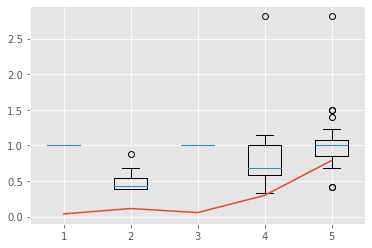

<Figure size 432x288 with 0 Axes>

In [73]:
# hidden node --- phi

p_datas['Phi']
result = []
# data = p_datas['Phi']
# plt.box_plot(data)
for i in range(5):
    result.append(p_datas[p_datas.data==i]['Phi'].values)

    
plt.boxplot(result)
# plt.twinx()
# plt.twiny()

a = p_datas[['data', 'Phi']]
b = nstate.sum(axis=1)
phi_ave = np.zeros(5)
for i in range(5):
    
    phi_ave[i] = a[a.data==i]['Phi'].sum()/b[i] #data=xのときのphi
plt.plot([1,2,3,4,5],phi_ave)

plt.show()
plt.savefig("hidden_phis")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9a740e7518>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9a740e7d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9a740e7128>,
 'medians': [<matplotlib.lines.Line2D at 0x7f9a740f0518>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f9a740f0908>,
 'means': []}

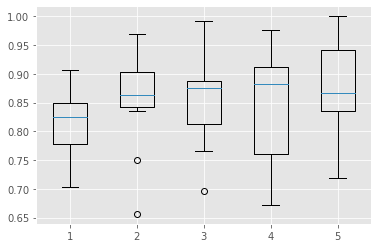

In [163]:
# hidden nodes ---- fitness
hid = np.zeros(50)
for i in range(5):
    for j in range(10):
        hid[i*10+j] += i

fit1 = fitness.reshape(5,10)[0]
fit2 = fitness.reshape(5,10)[1]
fit3 = fitness.reshape(5,10)[2]
fit4 = fitness.reshape(5,10)[3]
fit5 = fitness.reshape(5,10)[4]
plt.boxplot([fit1,fit2, fit3, fit4, fit5])

ValueError: x and y must have same first dimension, but have shapes (50,) and (44,)

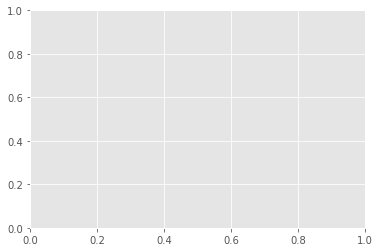

In [164]:
# fitness ---- phi

pp = p_datas['Phi'].values
plt.plot(fitness, pp)

[[1.         0.40775611]
 [0.40775611 1.        ]]


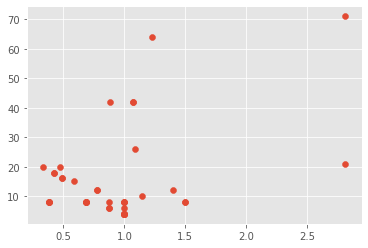

In [109]:
# purvs ---- phi

m = p_datas['nMechs'].values
p = p_datas['nPurvs'].values

ratio = p#/m

pp = p_datas['Phi'].values
order = pp.argsort() 

#
pp[order]
ratio[order]

po = pp[order][0:-2]
ro = ratio[order][0:-2]
print(np.corrcoef(pp, ratio))
#print(np.corrcoef(po, ro)[0,1])
plt.scatter(pp[order], ratio[order])

[[1.         0.41917449]
 [0.41917449 1.        ]]


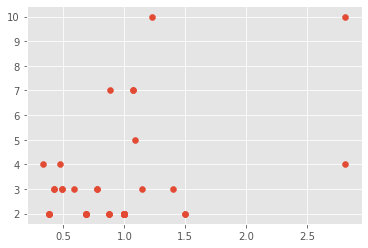

In [111]:
# concepts ---- phi

conc = p_datas['nConcepts'].values

pp = p_datas['Phi'].values
order = pp.argsort() 


pp[order]
conc[order]

# po = pp[order][0:-2]
# ro = ratio[order][0:-2]
print(np.corrcoef(pp, conc))
#print(np.corrcoef(po, ro)[0,1])
plt.scatter(pp[order], conc[order])

In [21]:
p_datas

,data,run,state,Phi,Sub,SizeofSub,nConcepts,nMechs,nPurvs
0,0,7,1,1.000000,"Subsystem(n4, n5)",2,2,2,6
1,1,4,0,0.875000,"Subsystem(n5, n6)",2,2,2,8
2,1,4,1,0.484376,"Subsystem(n4, n5, n6)",3,3,3,16
3,1,4,2,0.484376,"Subsystem(n4, n5, n6)",3,3,3,16
4,1,5,0,0.687499,"Subsystem(n5, n6)",2,2,2,8
5,1,5,2,0.381943,"Subsystem(n5, n6)",2,2,2,8
6,1,5,4,0.381943,"Subsystem(n5, n6)",2,2,2,8
7,1,8,0,0.381943,"Subsystem(n4, n5)",2,2,2,8
8,1,8,1,0.381943,"Subsystem(n4, n5)",2,2,2,8
9,2,0,1,1.000000,"Subsystem(n4, n5)",2,2,2,8


[[ 1.         -0.08232951]
 [-0.08232951  1.        ]]


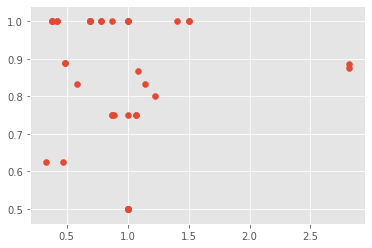

In [114]:
# average purview ---- phi

m = p_datas['nConcepts'].values
s = p_datas['SizeofSub'].values
p = p_datas['nPurvs'].values

ratio = ((p/m)/s)/2 # proportion of subsystem covered by the average purview

pp = p_datas['Phi'].values
order = pp.argsort() 

#
pp[order]
ratio[order]

po = pp[order][0:-2]
ro = ratio[order][0:-2]
print(np.corrcoef(pp, ratio))
#print(np.corrcoef(po, ro)[0,1])
plt.scatter(pp[order], ratio[order])